# Adyen Data Science Challenge

An important application of data science at Adyen is to protect our merchants from fraudulent transactions. Fraudulent transactions happen when a fraudster steals a legit customer's credit card, and uses it to unlawfully buy goods online. For this reason, Adyen has a risk system in place that can refuse a transaction if it is suspected to be fraudulent. The overall goal is to reject as much fraud as possible, without compromising legit customers.

Adyen knows that a transaction was fraudulent when it receives a chargeback. A chargeback is a notification from the card network that the amount of the transaction must be refunded to the legit customer. A chargeback can only happen on approved payments (i.e. if it was refused by our risk system or by the bank, money doesn't get deducted from the legit customer's account, thus no chargebacks can happen).


In this challenge, your goal is to train a model to predict which transaction might be fraudulent and improve Adyen's risk system. What is important for our merchants is that the chargeback rate should at all time stay below 1%, while keeping revenue as high as possible. A chargeback costs them 15 EUR, +50% of the price of the goods (in the form of lost goods that they sent to the fraudster). While declining a transaction that turned out to be non-fraudulent (false positive) also costs them 50% of the price of the goods (in the form of missed revenue).

## The dataset

In the dataset provided you'll find 30 days of payment data for a few merchants, a merchant is a client for which we process payments, e.g. an e-commerce website, different merchants are not necessarly different companies.

The dataset contains the following columns:

| Field | Explanation|
|:-----:| :------------------ |
| merchant | The id of our client |
| first_6_digit | The first 6 digit of the credit card used in the transaction which was recieved by our client |
| payment_ref | The unique reference for this payment |
| amount_eur | The amount in euros |
| card_network | The network that emitted the card (shown as SchemeX, where X is variable)|
| card_type | The type of card (debit,credit...)|
| timestamp | The timestamp when this specific payment was received |
| device_info | Information about the device used to perform the payment |
| risk_checks | A list of lists, each sub-list contains a weight in first position and a rule (ID) in the second. The weight (which we call a risk score) which is assigned to each rule is directly proportional to the likelihood of the payment being fraudulent (negative: unlikely to be fraudulent, zero: check is performed but not seen as important, above zero: more likely to be fraudulent).  Merchants can create custom rules to flag some payments as fraudulent. The weight can also be assigned manually. Not all possible checks might be triggered by a payment (eg. a check might be relevant only for one country) so not all the possible checks are always present in the list, in other words, not all checks are the same for each datarow.|
| refused_by_adyen_risk | Some of the risk-checks (rules) can force a payment to be refused; a refuse can also be caused by a predefined threshold on the risk-checks, such that if the score of the different rules exceed the threshold, the payment can be refused.|
| refused_by_bank | A payment can also be refused by the bank for various reasons (lack of funds, card lost etc..)|
| bank_country_id | The country ID of the bank |
| user_id | The id of the user that is performing the payment, this can be used to identify users performing multiple payments. Usually a fraudulent payment is enough to identify the user as fraudster, this means that all of their payments can be considered fraudulent.   |
| user_country_id | The country of the user that is performing the payment |
| autorised_times | An array that contains up to 50 timestamps of the most recent accepted payments of this user on our platform. If there are no previously known approved payments of this user on our platform the array is empty. |
| received_dates | An array that contains up to 50 timestamps of the most recent previously requested payments, populated only if the user has requested other payments on our platform before.|
| billing_address_dates | An array which contains the timestamps when a payment request with a different billing address was received, an empty list means we never receveived a request with a different address.
| delivery_address_dates | An array that will contain the timestamps when a payment request with a different delivery address was received, an empty list means we never receveived a request with a different delivery address.|
| ip_dates | An array that will contain the timestamps when a payment request with a different ip address, compared to the first payment, was received; an empty list means we never receveived a request with a different address. This list can be seen as a set.|
| is_fraud | Wether the payment was flagged as fraudulent. This happens when we receive a notification from the bank and can only happen for payments that were not already refused by adyen or by the bank.|


## Aim of the Challenge 

The aim of this challenge is to understand how you approach both a new problem as a new dataset. In order to understand this process please include markdown cells in which you discuss your choices with regards to the data preparation and model choices.


## Rules
You can start working right in this Jupyter Notebook, save the results and send to submit it. The data which you will need is provided in different formats (csv, json, parquet), feel free to choose the one that is most convienent for you.

(We will optionally accept submission in any other language/format as long as it comes with the full code and there is a clear explanation on how to execute it.)

Also there are bonus points if you can make your model into a REST API.

We kindly ask to submit your results within 48 hours since receiving this challenge.


### Imports ###

In [355]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

### Read in and inspect the dataset

In [356]:
df = pd.read_json('SupervisedChallenge.json', orient='records', lines=True)

In [357]:
# Inspet the data
df.head()

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,device,risk_checks,refused_by_adyen_risk,refused_by_bank,bank_country_id,user_id,user_country_id,authorised_times,received_dates,billing_address_dates,delivery_address_dates,ip_dates,is_fraud
0,Shop8,96543.0,78089c3946037ca9,0.00,SchemeF,DEBIT,2016-03-16 23:12:52,"[iPod, Mobile]","[[0, 82d8a3c9f6], [5, 6fe65e5dbc], [0, 5e9071e...",0,0,0.0,2.673933e+09,0.0,"[1458087107, 1458087043]","[1458169910, 1458169865, 1458169860, 145816981...",[],[],"[1458169910, 1458087107]",0
1,Shop8,579100.0,62c49a618760d829,0.00,SchemeD,DEBIT,2016-03-19 15:27:17,"[Other, Other]","[[0, 82d8a3c9f6], [100, 88c385a7f4], [100, 8b8...",1,0,1.0,2.684546e+09,1.0,[],"[1458401237, 1458400605]",[],[],[1458401237],0
2,Shop2,535041.0,75517f4497a164e1,6.00,SchemeF,CREDIT,2016-03-20 21:24:54,None,"[[-50, 82d8a3c9f6], [-100, c802faf604], [0, 7d...",0,0,2.0,2.238808e+09,2.0,"[1450624829, 1450466297, 1450376979, 144585067...","[1458509094, 1450624829, 1450466297, 145037697...",[],[],"[1458509094, 1450624829, 1450466297, 145037697...",0
3,Shop2,314986.0,aeecc3a05e7f472c,23.38,SchemeB,DEBIT,2016-04-12 21:00:15,"[Windows, Desktop]","[[-80, 82d8a3c9f6], [30, 4c1c7b7377], [-100, c...",0,0,6.0,2.104261e+09,3.0,"[1460494740, 1460494644, 1460494583, 146049447...","[1460494815, 1460494740, 1460494644, 146049458...",[],[],"[1460494815, 1459523677, 1459293160, 145886088...",0
4,Shop2,636420.0,de37ef13d0434bd8,9.79,SchemeB,DEFFERED_DEBIT,2016-03-15 17:38:40,"[Nintendo Switch, GamingConsole]","[[-150, 82d8a3c9f6], [30, 4c1c7b7377], [-100, ...",0,1,6.0,2.127859e+09,3.0,"[1458060011, 1457924207, 1457922002, 145792192...","[1458063520, 1458063499, 1458060011, 145792420...",[],[],"[1458063520, 1457924207, 1457885288, 145785274...",0


<br>
<br>
First thing's first, let's take a look at the distribution of the target variable, 'is_fraud':

In [413]:
df['is_fraud'].value_counts(normalize=True) * 100

0    99.481721
1     0.518279
Name: is_fraud, dtype: float64

Interesting. Fraud constitutes only about half a percent of the total dataset. An imbalanced class problem, if there ever was one. :)

<br>
<br>
We have a number of categorical features that we can potentially use for our model. Let's inspect their distributions visually.

Text(0.5, 1.0, 'Merchant Distribution (%)')

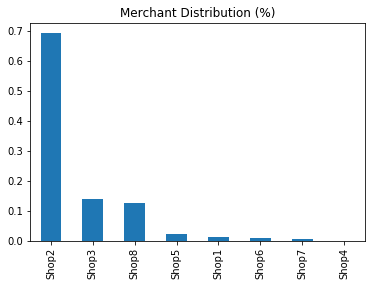

In [417]:
df['merchant'].value_counts(normalize=True).plot(kind='bar')
plt.title('Merchant Distribution (%)')

Text(0.5, 1.0, 'Card Network Distribution (%)')

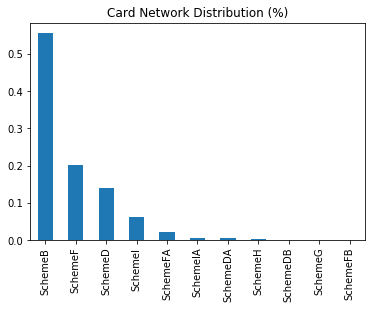

In [418]:
df['card_network'].value_counts(normalize=True).plot(kind='bar')
plt.title('Card Network Distribution (%)')

Text(0.5, 1.0, 'Card Type Distribution (%)')

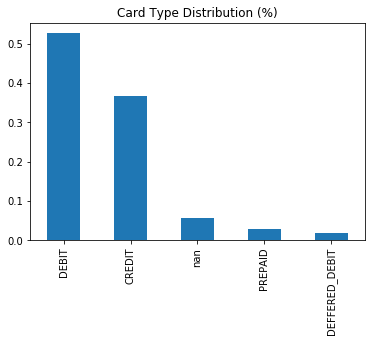

In [420]:
df['card_type'].value_counts(normalize=True, dropna=False).plot(kind='bar')
plt.title('Card Type Distribution (%)')

In [421]:
# Replace None device with empty list
df['device'] = df['device'].apply(lambda x: [] if x is None else x)

# Split device into device type and device family
df[['device_type','device_family']] = pd.DataFrame(df.device.values.tolist(), index=df.index)

# Replice None with Unknown
df['device_type'] = df['device_type'].apply(lambda x: 'Unknown' if x is None else x)
df['device_family'] = df['device_family'].apply(lambda x: 'Unknown' if x is None else x)

Text(0.5, 1.0, 'Device Type Distribution (%)')

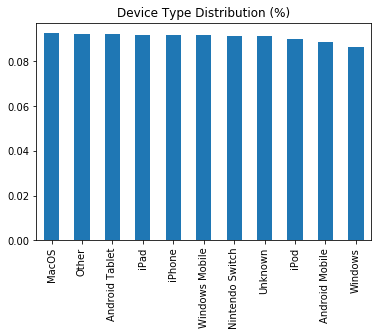

In [423]:
df['device_type'].value_counts(normalize=True).plot(kind='bar')
plt.title('Device Type Distribution (%)')

Text(0.5, 1.0, 'Device Family Distribution (%)')

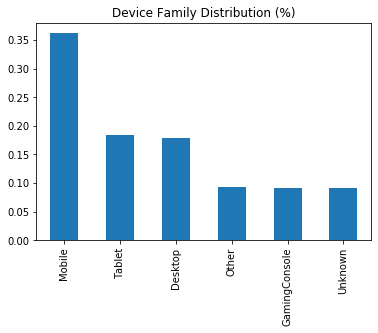

In [424]:
df['device_family'].value_counts(normalize=True).plot(kind='bar')
plt.title('Device Family Distribution (%)')

This is an interesting preliminary analysis, but it doesnt get to the meat of the problem - namely, the level of fraudulent transactions in each of these categories. Let's take a look at the percentages of fraud in the various features.

In [433]:
# Merchant fraud %
pd.DataFrame(df.groupby('merchant')['is_fraud'].mean() * 100)

,is_fraud
merchant,
Shop1,2.979516
Shop2,0.675653
Shop3,0.067420
Shop4,0.000000
Shop5,0.210526
Shop6,0.000000
Shop7,0.000000
Shop8,0.000000


In [432]:
# Card Network fraud %
pd.DataFrame(df.groupby('card_network')['is_fraud'].mean() * 100)

,is_fraud
card_network,
SchemeB,0.848868
SchemeD,0.180624
SchemeDA,0.000000
SchemeDB,0.000000
SchemeF,0.091137
SchemeFA,0.105485
SchemeFB,0.000000
SchemeG,0.000000
SchemeH,0.000000


In [434]:
# Card Type fraud %
pd.DataFrame(df.groupby('card_type')['is_fraud'].mean())

,is_fraud
card_type,
CREDIT,0.005302
DEBIT,0.005492
DEFFERED_DEBIT,0.000000
PREPAID,0.000000


In [435]:
pd.DataFrame(df.groupby('device_type')['is_fraud'].mean()*100)

,is_fraud
device_type,
Android Mobile,0.392157
Android Tablet,0.427028
MacOS,0.673821
Nintendo Switch,0.607749
Other,0.476908
Unknown,0.456505
Windows,0.563154
Windows Mobile,0.554435
iPad,0.502892


In [436]:
pd.DataFrame(df.groupby('device_family')['is_fraud'].mean() * 100)

,is_fraud
device_family,
Desktop,0.620476
GamingConsole,0.607749
Mobile,0.498403
Other,0.476908
Tablet,0.464941
Unknown,0.456505


In [439]:
pd.DataFrame(df.groupby('refused_by_adyen_risk')['is_fraud'].mean() * 100)

,is_fraud
refused_by_adyen_risk,
0,0.547276
1,0.000000


In [440]:
pd.DataFrame(df.groupby('refused_by_bank')['is_fraud'].mean() * 100)

,is_fraud
refused_by_bank,
0,0.591607
1,0.000000


In [374]:

df['bank_country_id'] = df['bank_country_id'].apply(lambda x: str(x))

In [375]:
df['bank_country_id'] = df['bank_country_id'].str.replace('nan', 'unknown')

In [376]:
# Top 5 fradulent bank countries
df.groupby('bank_country_id')['is_fraud'].mean().sort_values(ascending=False)[0:5]

bank_country_id
89.0     0.200000
105.0    0.010989
6.0      0.006512
68.0     0.002008
45.0     0.000545
Name: is_fraud, dtype: float64

In [377]:
df.groupby('bank_country_id')['is_fraud'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
bank_country_id,,,,,,,,
89.0,5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0
105.0,91.0,0.010989,0.104828,0.0,0.0,0.0,0.0,1.0
6.0,33322.0,0.006512,0.080436,0.0,0.0,0.0,0.0,1.0
68.0,498.0,0.002008,0.044811,0.0,0.0,0.0,0.0,1.0
45.0,7342.0,0.000545,0.023336,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
35.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
34.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
33.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [378]:
# Top 5 fradulent user countries
df['user_country_id'] = df['user_country_id'].apply(lambda x: str(x))
df['user_country_id'] = df['user_country_id'].str.replace('nan', 'unknown')
df.groupby('user_country_id')['is_fraud'].mean().sort_values(ascending=False)[0:5]

user_country_id
unknown    0.009623
6.0        0.005335
45.0       0.000315
97.0       0.000000
2.0        0.000000
Name: is_fraud, dtype: float64

<br>
<br>

### Feature Engineering ###

As a first step, we're going to do one-hot encoding of some of the fetures in our dataset, in order to make them more palatable to Machine Learning algorithms. This is a process in which a categorical feature is converted into a number of binary features, where the number of new features matches the number of levels in the original feature. This can be achivied using scikit-learn's OneHotEncoder, but here we use pandas' get_dummies() functionality, as it produces the same result. We make sure to set the 'dummy_na' parameter to 'True', in order to make sure that missing values get a new column/indicator variable of their own. 

In [379]:
# Merchant
merchant_dummies = pd.get_dummies(df['merchant'], prefix='is_merchant', prefix_sep='_', dummy_na=True, drop_first=False)

# Card network
card_network_dummies = pd.get_dummies(df['card_network'], prefix='is_card_network', prefix_sep='_', dummy_na=True, drop_first=False)

# Card type
card_type_dummies = pd.get_dummies(df['card_type'], prefix='is_card_type', prefix_sep='_', dummy_na=True, drop_first=False)

# Device type
device_type_dummies = pd.get_dummies(df['device_type'], prefix='is_device_type', prefix_sep='_', dummy_na=True, drop_first=False)

# Device family
device_family_dummies = pd.get_dummies(df['device_family'], prefix='is_device_family', prefix_sep='_', dummy_na=True, drop_first=False)

<br>
<br>
Next, we have another set of features, including the countries that fraud has been committed from most often historically.

In [380]:
# Bank country matches user country
df['bank_eq_user_country'] = np.where(df['bank_country_id'] == df['user_country_id'], 1, 0)

# Count of authorised times
df['authorised_times_cnt'] = df['authorised_times'].apply(lambda x: len(x))

# Count of received dates
df['received_date_cnt'] = df['received_dates'].apply(lambda x: len(x))

# Count of billing address dates
df['billing_addr_date_cnt'] = df['billing_address_dates'].apply(lambda x: len(x))

# Count of delivery address dates
df['delivery_addr_date_cnt'] = df['delivery_address_dates'].apply(lambda x: len(x))

# Count of IP dates
df['ip_dates_cnt'] = df['ip_dates'].apply(lambda x: len(x))

# Top 5 fradulent bank countries
df['is_bank_country_89'] = np.where(df['bank_country_id'] == '89.0', 1, 0)
df['is_bank_country_105'] = np.where(df['bank_country_id'] == '105.0', 1, 0)
df['is_bank_country_6'] = np.where(df['bank_country_id'] == '6.0', 1, 0)
df['is_bank_country_68'] = np.where(df['bank_country_id'] == '68.0', 1, 0)
df['is_bank_country_45'] = np.where(df['bank_country_id'] == '45.0', 1, 0)

# Top 3 fradulent user countries
df['is_user_country_unknown'] = np.where(df['user_country_id'] == 'unknown', 1, 0)
df['is_user_country_6'] = np.where(df['user_country_id'] == '6.0', 1, 0)
df['is_user_country_45'] = np.where(df['user_country_id'] == '45.0', 1, 0)

<br>
<br>
Finally, we crate features based on the timestamp:

In [403]:
# Day of week
df['dow'] = df['timestamp'].apply(lambda x: x.dayofweek)
dow_dummies = pd.get_dummies(df['dow'], prefix='is_dow', prefix_sep='_', dummy_na=True, drop_first=False)

# Hour of the day
df['hour'] = df['timestamp'].apply(lambda x: x.hour)
hour_dummies = pd.get_dummies(df['hour'], prefix='is_hour', prefix_sep='_', dummy_na=True, drop_first=False)

<br>
<br>
Now we create a master dataset containing all the features that will be used for modeling:

In [383]:
# Create new dataframe for modeling
modeling_df = pd.concat([df[['bank_eq_user_country',
                        'authorised_times_cnt',
                        'received_date_cnt',
                        'billing_addr_date_cnt',
                        'delivery_addr_date_cnt',
                        'ip_dates_cnt',
                        'is_bank_country_89',
                        'is_bank_country_105',
                        'is_bank_country_6',
                        'is_bank_country_68',
                        'is_bank_country_45',
                        'is_user_country_unknown',
                        'is_user_country_6',
                        'is_user_country_45',
                        'amount_eur',
                        'refused_by_adyen_risk',
                        'refused_by_bank']],
                        merchant_dummies,
                        card_network_dummies,
                        card_type_dummies,
                        device_family_dummies,
                        device_type_dummies,
                        dow_dummies,
                        hour_dummies],
                        axis=1)

In [404]:
# Inspect the dataframe
modeling_df.head()

,bank_eq_user_country,authorised_times_cnt,received_date_cnt,billing_addr_date_cnt,delivery_addr_date_cnt,ip_dates_cnt,is_bank_country_89,is_bank_country_105,is_bank_country_6,is_bank_country_68,...,is_hour_15.0,is_hour_16.0,is_hour_17.0,is_hour_18.0,is_hour_19.0,is_hour_20.0,is_hour_21.0,is_hour_22.0,is_hour_23.0,is_hour_nan
0,1,2,7,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,2,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,15,16,0,0,5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,50,50,0,0,15,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,50,50,0,0,15,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


<br>
<br>

### Train/Test Split ###

In order to successfully train a model, we can't use the entire dataset. Training and testing a model on the same data can lead to overfitting, as we can't be sure how the model will generalize, i.e. perform on new, unseen data. This is why we split our original dataset into a trainining dataset, used for building a model, and a testing dataset, used for testing the model's performance on new data. Ratio's of 80:20 and 70:30 are common, and here we'll go with 70:30, due to the small number of cases. We'll also set the seed for the random number generator, in order to ensure reproducibility. Finally, we'll opt for stratified sampling, in order to ensure that the distribution of classes in both datasets is as close as possible.

In [385]:
X_train, X_test, y_train, y_test = train_test_split(modeling_df, df['is_fraud'],
                                                    test_size=0.3, random_state=176, stratify=df['is_fraud'])

Let's verify that the proportion of fraud is similar in the two datasets:

In [386]:
y_train.mean()

0.0051893964434454945

In [387]:
y_test.mean()

0.005167360789757828

<br>
<br>

### Preparing the Data for Resampling ###

As we've seen from the numbers, we're facing a significant class imbalance. Just training a model on the dataset as it is will produce good results on the majority class, but terrible results on the positive class (fraud, in our case). The tricky part here is that looking at just the overall accuracy will show great results - but this is deceiving. For class imbalance problems, it's important to look at alternative model metrics, such as Recall, F1 Score (the harmonic mean of Precision and Recall), and the Area under the ROC Curce (AUC).

Class imbalance is also where resampling techniques come into play. These techniques are used to balance out the training set, allowing for better accuracy of the model on the positive class. The caveat is that, very often, we have to sacrifice the accuracy on the negative class - increasing the number of False Positives, in order to increase the number of True Positives.

Before resampling, we'll prepare our data.

In [388]:
# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
not_fraud = X[X.is_fraud == 0]
fraud = X[X.is_fraud == 1]

For modeling, we will turn to the Random Forest algorithm, which tends to produce powerful models straight out of the box, without much hyperparameter tuning. Another great aspect of the algorithm is that it does automatic feature selection.

<br>
<br>

### Upsampling of the Minority Class ###

Upsampling (oversampling) can be defined as adding more copies of the minority class. Upsampling can be a good choice when we don't have a ton of data to work with, which is the case here.

We will use the resampling module from scikit-learn to randomly replicate samples from the minority class. After resampling we have an equal ratio of data points for each class!

In [389]:
# Upsample the minority class
fraud_upsampled = resample(fraud,
                          replace=True, # Sample with replacement
                          n_samples=len(not_fraud), # Match number in majority class
                          random_state=922) # Set the seed for reproducible results

# Combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [390]:
y_train = upsampled.is_fraud
X_train = upsampled.drop('is_fraud', axis=1)

upsampled_rf = RandomForestClassifier(random_state=471).fit(X_train, y_train)
upsampled_preds = upsampled_rf.predict(X_test)

In [391]:
upsampled_accuracy = accuracy_score(y_test, upsampled_preds)
upsampled_balanced_acc = balanced_accuracy_score(y_test, upsampled_preds)
upsampled_recall = recall_score(y_test, upsampled_preds)
upsampled_f1 = f1_score(y_test, upsampled_preds)
upsampled_auc = roc_auc_score(y_test, upsampled_preds)

<br>
<br>

### Downsampling the Majority Class ###

Downsampling (undersampling) can be defined as removing some observations of the majority class. Downsampling can be a good choice when we have a large amount of data. But, a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from scikit-learn to randomly remove samples from the majority class. We have an equal ratio of fraud to not fraud data points, but in this case a much smaller quantity of data to train the model on.

In [392]:
# Downsample majority class
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # Sample without replacement
                                n_samples = len(fraud), # Match minority n
                                random_state = 222) # Random seed for reproducible results

# Combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

In [393]:
# Create the training and test set again
y_train = downsampled.is_fraud
X_train = downsampled.drop('is_fraud', axis=1)

# Train the Random Foresr classifier and generate predictions
downsampled_rf = RandomForestClassifier(random_state=176).fit(X_train, y_train)
downsampled_preds = downsampled_rf.predict(X_test)

In [394]:
# Calculate accuracy metrics
downsampled_accuracy = accuracy_score(y_test, downsampled_preds)
downsampled_balanced_acc = balanced_accuracy_score(y_test, downsampled_preds)
downsampled_recall = recall_score(y_test, downsampled_preds)
downsampled_f1 = f1_score(y_test, downsampled_preds)
downsampled_auc = roc_auc_score(y_test, downsampled_preds)

<br>
<br>

### Resampling using the Synthetic Minority Oversampling Technique ###

A technique similar to upsampling is to create synthetic samples. Here we will use imblearn's SMOTE, or Synthetic Minority Oversampling Technique (sometimes also known as SMOTEboost). SMOTE uses a k-nearest neighbors algorithm to generate new and synthetic data we can use for training our model. (The default value of k is 5.)

Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [395]:
# Create the synthetics training data
sm = SMOTE(random_state=205)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [396]:
# Train a Random Forest Classifier and generate predictions
smote_rf = RandomForestClassifier(random_state=366).fit(X_train, y_train)
smote_preds = smote_rf.predict(X_test)

In [397]:
# Calculate accuracy metrics
smote_accuracy = accuracy_score(y_test, smote_preds)
smote_balanced_acc = balanced_accuracy_score(y_test, smote_preds)
smote_recall = recall_score(y_test, smote_preds)
smote_f1 = f1_score(y_test, smote_preds)
smote_auc = roc_auc_score(y_test, smote_preds)

<br>
<br>

### Comparison with Adyen's Risk System ###

The ultimate goal for this project is to build a model that will be an improvement over Adyen's existing system. In order to compare performance, we'll calculate all of the metrics for Adyen's system as well.

In [398]:
adyen_accuracy = accuracy_score(y_test, X_test['refused_by_adyen_risk'])
adyen_balanced_acc = balanced_accuracy_score(y_test, X_test['refused_by_adyen_risk'])
adyen_recall = recall_score(y_test, X_test['refused_by_adyen_risk'])
adyen_f1 = f1_score(y_test, X_test['refused_by_adyen_risk'])
adyen_auc = roc_auc_score(y_test, X_test['refused_by_adyen_risk'])

<br>
<br>

### Showing the Results of the Random Forest Algorithm on Various Resampled Datasets ###

Now we're going to create a DataFrame which shows the various accuracy metrics for each of the models, and compare them with the metrics for Adyen's system.

In [399]:
metrics = {'Accuracy': [upsampled_accuracy, downsampled_accuracy, smote_accuracy, adyen_accuracy],
           'Balanced Accuracy': [upsampled_balanced_acc, downsampled_balanced_acc, smote_balanced_acc, adyen_balanced_acc],
           'Recall': [upsampled_recall, downsampled_recall, smote_recall, adyen_recall],
           'F1 Score': [upsampled_f1, downsampled_f1, smote_f1, adyen_f1],
           'AUC': [upsampled_auc, downsampled_auc, smote_auc, adyen_auc]}

In [400]:
metrics_df = pd.DataFrame(metrics, index=['Upsampling', 'Downsampling', 'SMOTE', 'Adyen'])

In [401]:
metrics_df

,Accuracy,Balanced Accuracy,Recall,F1 Score,AUC
Upsampling,0.994833,0.500000,0.000000,0.000000,0.500000
Downsampling,0.758214,0.767120,0.776119,0.032109,0.767120
SMOTE,0.748496,0.777084,0.805970,0.032057,0.777084
Adyen,0.941771,0.473331,0.000000,0.000000,0.473331


<br>
<br>

### ROC Curve for the SMOTE Random Forest ###

Let's plot the Receiver Operating Characteristic curve for the winning model. This curve plots the relationship between the True Positive Rate (a.k.a. Sensitivity) and the False Positive Rate (a.k.a. 1 - Specificity).

In [270]:
fpr, tpr, thresholds = roc_curve(y_test, smote_preds, pos_label=1)

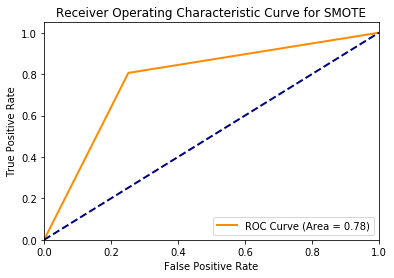

In [289]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve (Area = %0.2f)' % smote_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for SMOTE')
plt.legend(loc="lower right")

<br>
<br>

### Feature Importance ###

Finally, let's show the relative importance of the top 20 features. Feature importance is calculated by reshuffling the rows of each feature, re-fitting the model and re-predicting, and calculating the drop in accuracy after this is done.

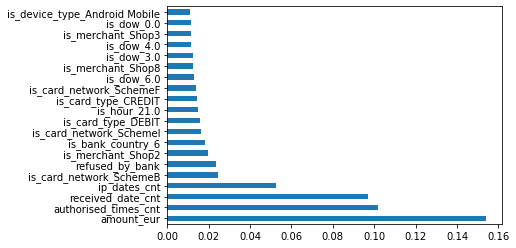

In [402]:
feat_importances = pd.Series(smote_rf.feature_importances_, index=modeling_df.columns)
feat_importances.nlargest(20).plot(kind='barh')

<br>
<br>

### Next Steps ###

There are a number of steps that could be taken to improve performance, that form the basis for future work:

1. Using different levels of balancing the training dataset during resampling: so far, for upsampling and downsampling we've made sure that the ratio of positive to negative classes is 1:1, but this doesn't have to be so. We can uses various ratios for these two methos, and different values of k for SMOTE.
2. We can tune the hyperparameters for the Random Forest classifier, primarily by increasing the number of trees.
3. We can try other algorithms that have shown to be powerful in practice, such as XGBoost.